# Importing packages

In [1]:
import numpy as np
import jax.numpy as jnp
import oracle
from data_processing import download_and_process_data
from compression_operator import Top_k
import algorithms
from copy import deepcopy
from matplotlib import pyplot as plt
import pickle

In [41]:
import matplotlib.ticker as tck

# Phishing

## Download and modify the dataset

In [2]:
num_clients = 20

In [3]:
lambda_ = 0.1

In [146]:
dataset_name = 'a9a'

In [147]:
X, y, data = download_and_process_data(dataset_name, num_clients)

Dataset is downloaded.
Data is evenly divided between 20 clients


In [148]:
d = X.shape[1]

## Create oracles

In [149]:
oracle_container = oracle.NoncvxLogRegContainer(data, lambda_)
L = oracle_container.compute_smoothness()
L_tilde = oracle_container.compute_distributed_smoothness()
print('Oracle used is {}. Smoothness constant (L) is {}. Distributed \
smoothness (L_tilde) is {}.'.format(oracle_container.__class__.__name__, L,
                                    L_tilde))

Oracle used is NoncvxLogRegContainer. Smoothness constant (L) is 1.771933121163916. Distributed smoothness (L_tilde) is 1.7730809699874066.


# Run algorithms

In [ ]:
stepsize_scales = 2 ** np.arange(0, 11, 2)

In [ ]:
stepsize_scales

In [ ]:
x_0 = jnp.zeros(d)

In [ ]:
max_comm = 10000

In [ ]:
zetas = np.geomspace(2 ** -8, 2 ** 8, 5)

In [ ]:
zetas

In [ ]:
zetas = np.insert(zetas, 0, 0)

In [ ]:
zetas

In [ ]:
ks = [1, int(d / 4), int(d/2), d]

In [ ]:
ks

In [ ]:
time_limit = 180

### EF21

In [ ]:
histories = dict()

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
for k in ks:
    c_op = Top_k(k)
    beta = c_op.beta(d)
    theta = c_op.theta(d)
    for zeta in zetas:
        theoretical_stepsize = 1. / (L + L_tilde * np.sqrt(
            max(zeta, beta) / theta))
        history_best = [np.float32('inf')]
        history_comm_best = None
        best_scale = None
        for stepsize_scale in stepsize_scales:
            print('{}-{}-{}'.format(k, zeta, stepsize_scale))
            stepsize = stepsize_scale * theoretical_stepsize
            history, history_comm = algorithms.CLAG(x_0,
                                                    oracle_container,
                                                    c_op,
                                                    stepsize,
                                                    zeta,
                                                    max_comm,
                                                    time_limit)
            print('')
            if history[-1] < history_best[-1]:
                history_best = deepcopy(history)
                history_comm_best = deepcopy(history_comm)
                best_scale = stepsize_scale
        histories[(k, zeta)] = (history_comm_best, history_best, best_scale)
        with open('../results/histories_{}_2.pickle'.format(dataset_name), 'wb') as file:
            pickle.dump(histories, file)

In [ ]:
with open('../results/histories_phishing.pickle', 'rb') as file:
    histories_2 = pickle.load(file)

In [ ]:
histories_full = {**histories, **histories_2}

In [ ]:
with open('../results/histories_phishing.pickle', 'wb') as file:
    pickle.dump(histories_full, file)

In [ ]:
histories = deepcopy(histories_full)

# Plots

In [150]:
with open('../results/histories_{}_plot.pickle'.format(dataset_name), 'rb') as file:
    histories = pickle.load(file)

In [151]:
float_bits = 32

In [152]:
bit_scale = 1000

In [153]:
histories_2 = {}
for k, v in histories.items():
    comm, norm, scale = v
    comm_ = [x * float_bits / (num_clients * bit_scale) for x in comm]
    norm_ = [x ** 2 for x in norm]
    histories_2[k] = (comm_, norm_, scale)

In [154]:
ks = [1, int(d / 4), int(d/2), d]

In [155]:
zetas = np.geomspace(2 ** -8, 2 ** 8, 5)
zetas = np.insert(zetas, 0, 0)

In [117]:
size = 40
marker_size = 30
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 4
# plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.labelsize'] = size  # 40
plt.rcParams['ytick.labelsize'] = size  # 40
plt.rcParams['legend.fontsize'] = 30  # 30
plt.rcParams['axes.titlesize'] = size  # 40
plt.rcParams['axes.labelsize'] = size  # 40
plt.rcParams["figure.figsize"] = [50, 20]

1
30
61


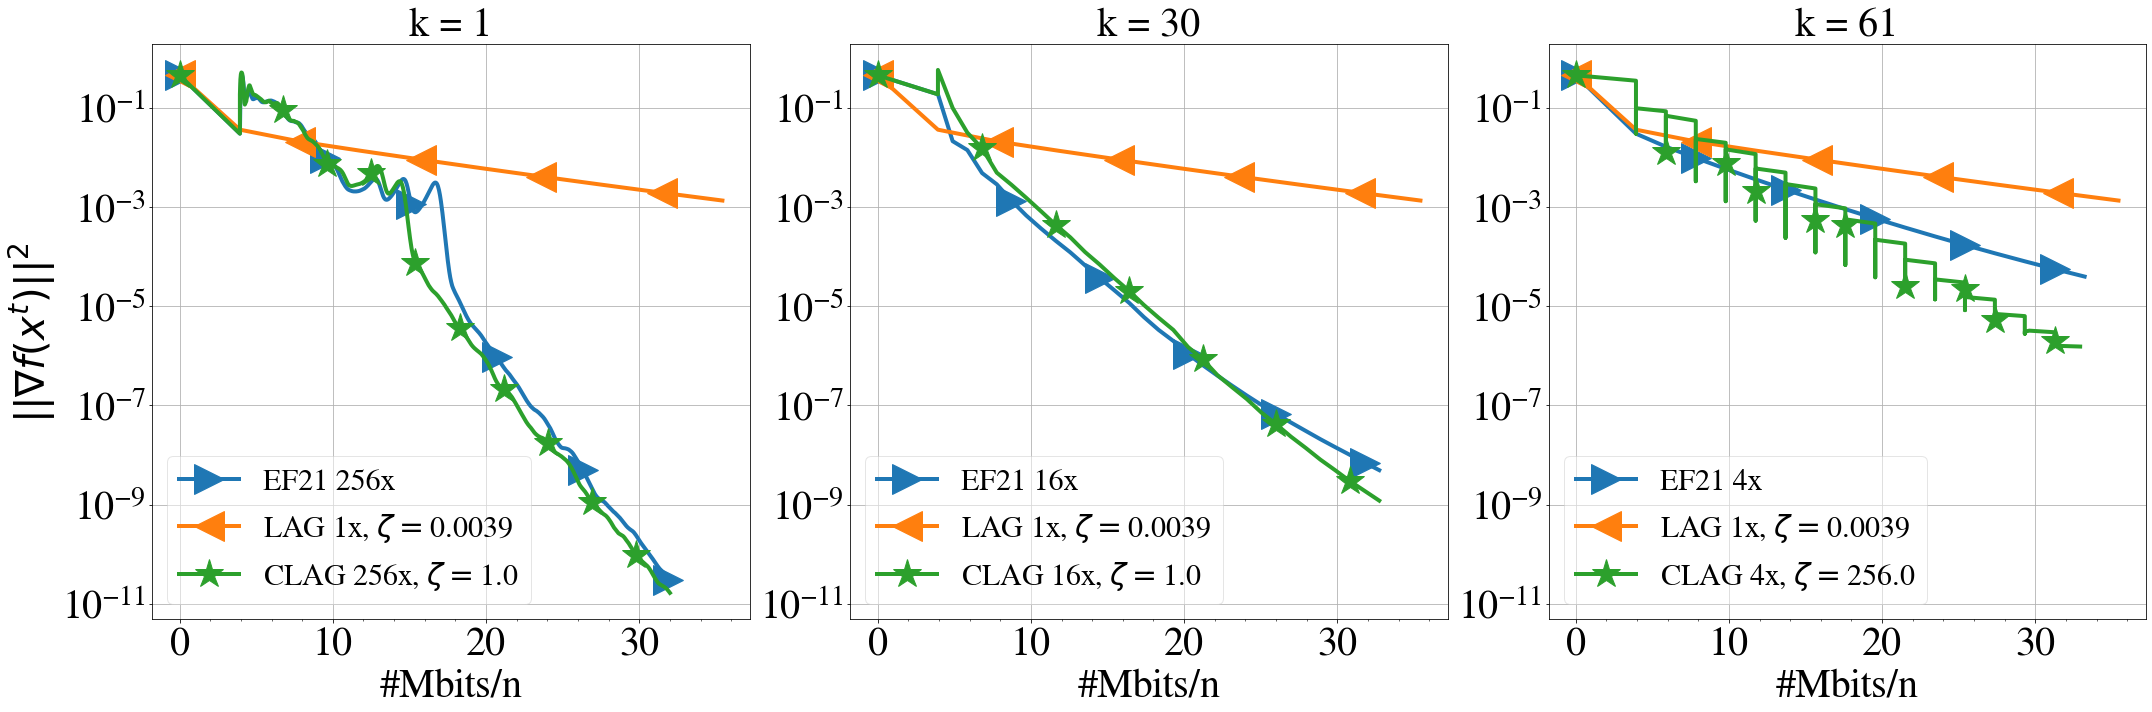

In [160]:
fig, ax = plt.subplots(nrows=1, ncols=len(ks) - 1, figsize=(30, 10),
                       sharey=True)
# LAG
best_zeta_lag = zetas[1]
for zeta in zetas[2:]:
    if histories_2[(d, zeta)][1][-1] < histories_2[(d, best_zeta_lag)][1][-1]:
        best_zeta = zeta
comm_lag, norm_lag, scale_lag = histories_2[(d, best_zeta_lag)]
for k_id, k in enumerate(ks[:-1]):
    print(k)
    # EF21
    comm_ef21, norm_ef21, scale_ef21 = histories_2[(k, 0)]
    ax[k_id].plot(comm_ef21, norm_ef21, label='EF21 {}x'.format(scale_ef21),
                  marker='>', markevery=int(len(comm_ef21) / 5), ms=30)
    # LAG
    ax[k_id].plot(
        comm_lag,
        norm_lag,
        label='LAG {}x, $\zeta=${}'.format(scale_lag, round(best_zeta_lag, 4)),
        marker='<',
        markevery=int(len(comm_lag) / 10) + 1,
        ms=30
    )
    # CLAG
    best_zeta = zetas[1]
    for zeta in zetas[2:]:
        if histories_2[(k, zeta)][1][-1] < histories_2[(k, best_zeta)][1][-1]:
            best_zeta = zeta
    comm_clag, norm_clag, scale_clag = histories_2[(k, best_zeta)]
    locmin = tck.LogLocator(base=10.0, subs=(
        0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8), numticks=10)
    ax[k_id].plot(comm_clag,
                  norm_clag,
                  label='CLAG {}x, $\zeta=${}'.format(
                    scale_clag, round(best_zeta, 4)),
                  marker='*',
                  markevery=int(len(comm_clag) / 10) + 2,
                  ms=30)
    ax[k_id].set_yscale('log')
    ax[k_id].set_xlabel('#Mbits/n')
    if k_id == 0:
        ax[k_id].set_ylabel(r'$||\nabla f(x^t)||^2$')
    ax[k_id].legend(loc="best", framealpha=0.5)
    ax[k_id].grid()
    ax[k_id].locator_params(axis='x', nbins=4)
    ax[k_id].xaxis.set_minor_locator(tck.AutoMinorLocator(5))
    ax[k_id].yaxis.set_minor_locator(locmin)
    ax[k_id].yaxis.set_tick_params(which='both',
                                   direction='out',
                                   labelbottom=True)
    ax[k_id].set_yticks(np.geomspace(1e-11, 1e-1, 6))
    ax[k_id].set_title('k = {}'.format(k))
    fig.tight_layout()
    fig.savefig('../plots/plot_{}.pdf'.format(dataset_name))